<a href="https://colab.research.google.com/github/pranavrelds/credit-card-data-clustering/blob/main/Credit_Card_Data_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import glorot_uniform

# Configurations

In [111]:
DIR = '/content/drive/MyDrive/Credit Card Data For Clustering/'
TSNE_DIM = 2
PCA_DIM = 2
ENCODING_DIM = 7

# Loading Dataset
DF = pd.read_csv(DIR+'Marketing_data.csv')
DF.head(2)
# Description of columns --> https://www.kaggle.com/arjunbhasin2013/ccdata

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.4,0.0,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12


# EDA

In [112]:
print('Number of datapoints : ', DF.shape[0])
print('Number of features : ', DF.shape[1])

Number of datapoints :  8950
Number of features :  18


In [113]:
DF.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


**Observations:**
* Mean balance is 1564 

* Balance frequency is frequently updated on average ~0.9
* Purchases average is 1000

* One off purchase average is ~600
* Average purchases frequency is around 0.5
* Average ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, and CASH_ADVANCE_FREQUENCY are low
* Average credit limit ~ 4500
* Percent of full payment is 15%
* Average tenure is 11 years

In [114]:
# Max ONEOFF_PURCHASES purchase
DF[DF['ONEOFF_PURCHASES'] == 40761.250000]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
550,C10574,11547.52001,1.0,49039.57,40761.25,8278.32,558.166886,1.0,1.0,0.916667,0.083333,1,101,22500.0,46930.59824,2974.069421,0.25,12


In [115]:
# Customer with cash advance of $47137
DF[DF['CASH_ADVANCE'] == 47137.211760000006]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2159,C12226,10905.05381,1.0,431.93,133.5,298.43,47137.21176,0.583333,0.25,0.5,1.0,123,21,19600.0,39048.59762,5394.173671,0.0,12


**Observations:**

* This customer made 123 cash advance transactions!!
* Never paid credit card in full



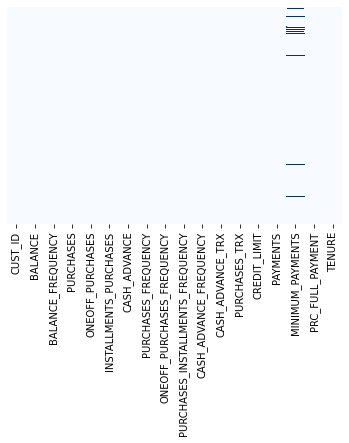

In [116]:
# Check for missing values
sns.heatmap(DF.isnull(),yticklabels= False, cbar= False, cmap='Blues')

In [117]:
# Number of missing values in each column
DF.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [118]:
# Fill up the missing values with mean of the 'MINIMUM_PAYMENT' 
DF.loc[DF['MINIMUM_PAYMENTS'].isnull() == True, 'MINIMUM_PAYMENTS'] = DF['MINIMUM_PAYMENTS'].mean()

# Fill up the missing value with mean of the 'CREDIT_LIMIT' 
DF.loc[DF['CREDIT_LIMIT'].isnull() == True, 'CREDIT_LIMIT'] = DF['CREDIT_LIMIT'].mean()
DF.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

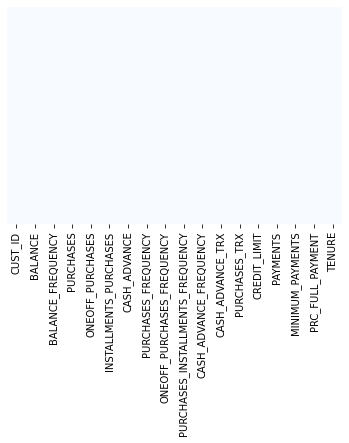

In [119]:
# Check again for missing values
sns.heatmap(DF.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [120]:
# Check for duplicated entries in the data
DF.duplicated().sum()

0

In [121]:
# Dropping Customer ID Column 
DF.drop('CUST_ID', axis=1, inplace= True)
DF.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


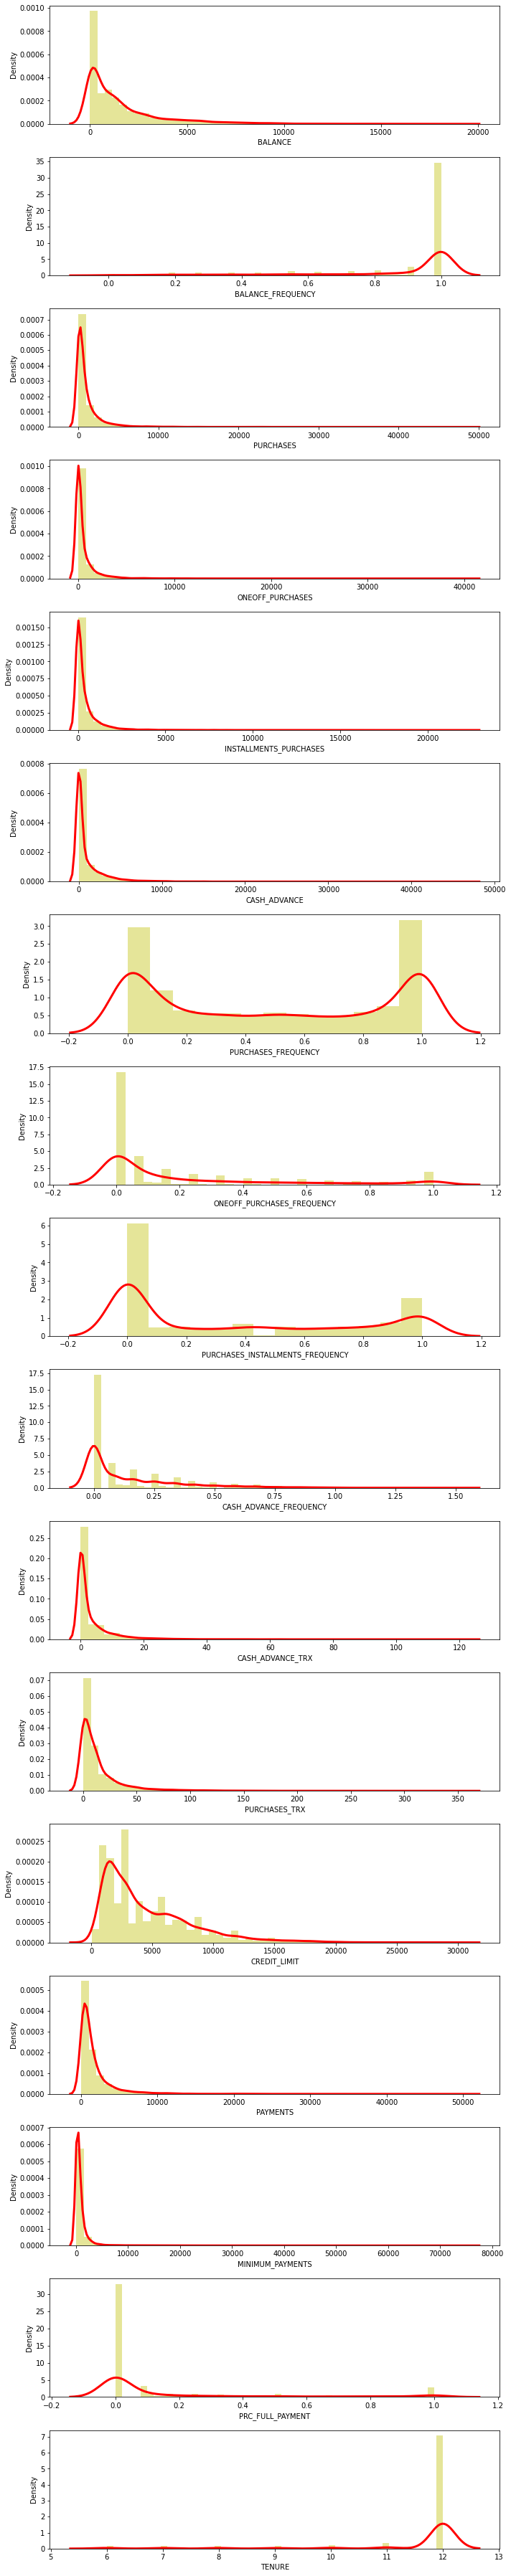

In [122]:
# Distribution of each column in the dataset
plt.figure(figsize = (10,50))
for i in range(len(DF.columns)):
  plt.subplot(17, 1, i+1)
  sns.distplot(DF[DF.columns[i]], kde_kws={"color": "r", "lw": 3, "label": "KDE"}, hist_kws={"color": "y"}) 

plt.tight_layout()
plt.show()

**Observations:**

* Mean of balance is 1500
* 'Balance_Frequency' for most customers is updated frequently ~1
* For 'PURCHASES_FREQUENCY', there are two distinct group of customers
*  For 'ONEOFF_PURCHASES_FREQUENCY' and 'PURCHASES_INSTALLMENT_FREQUENCY' most users didn't prefer one off puchases or installment purchases frequently 
*  Very small number of customers pay their balance in full 'PRC_FULL_PAYMENT'~0
*  Credit limit average is around 4500
*  Most customers have ~12 years tenure


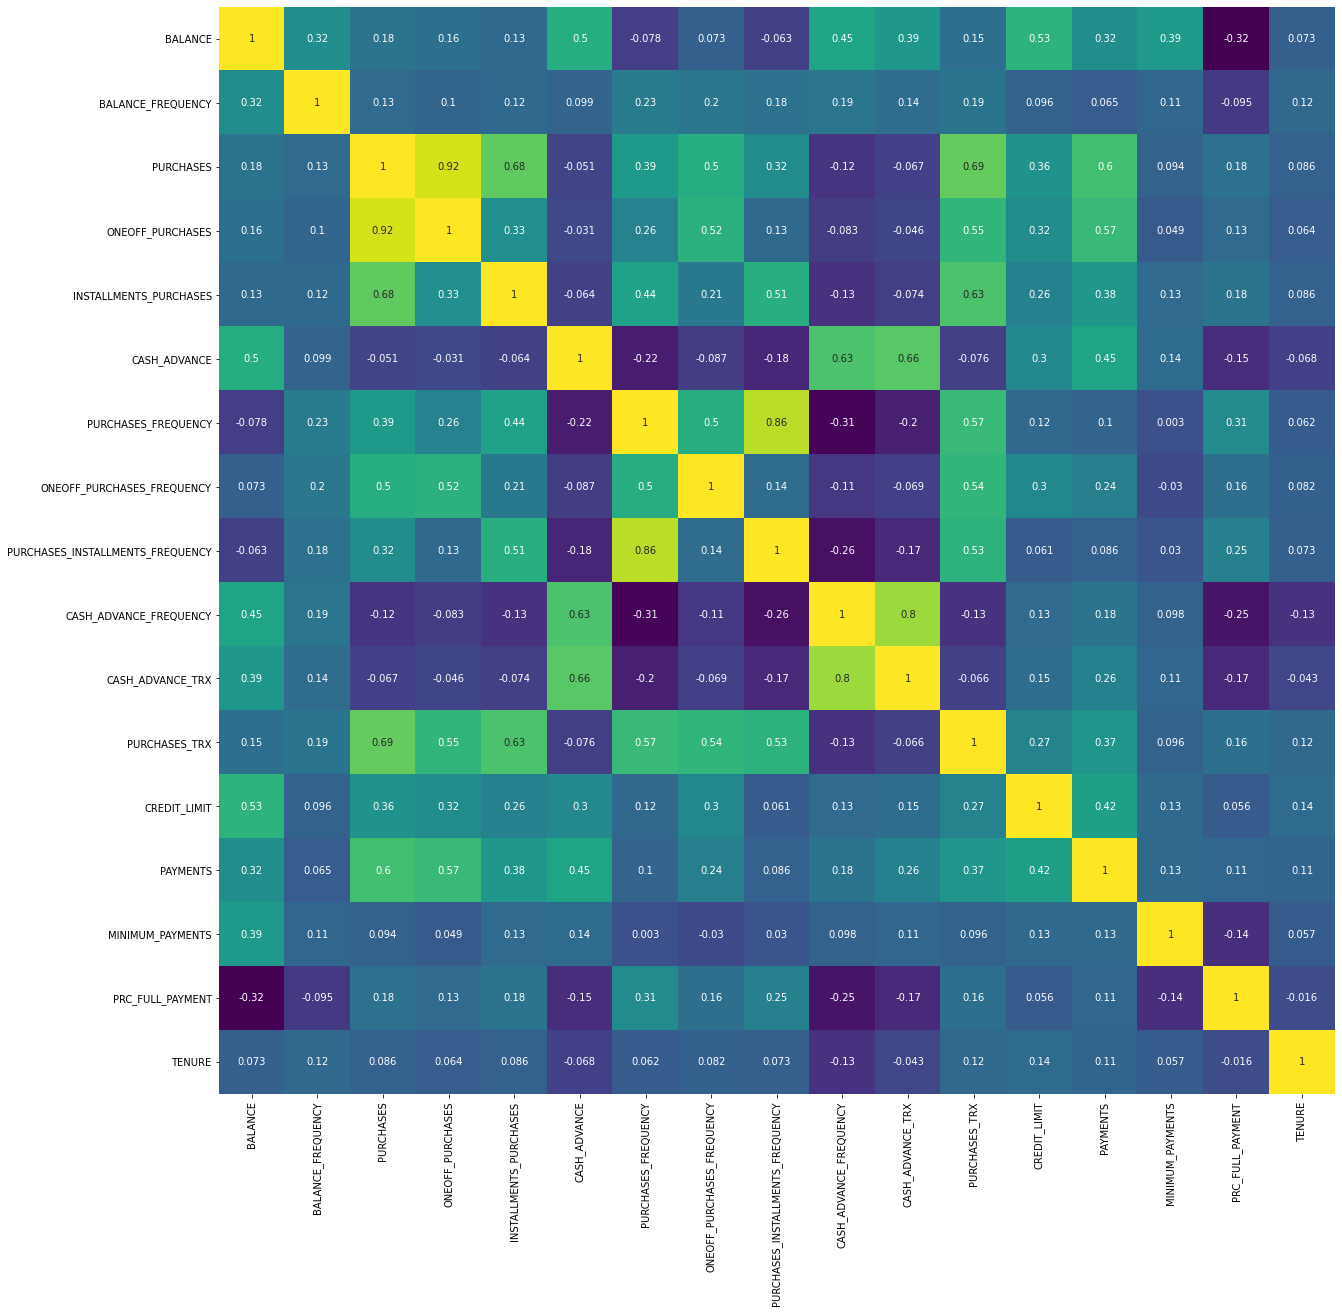

In [123]:
# Correlation
plt.figure(figsize=(20,20))
sns.heatmap(DF.corr(), annot=True, cbar=False, cmap='viridis')
plt.show()

**Observation:**
* 'PURCHASES' have high correlation between one-off purchases, 'installment purchases, purchase transactions, credit limit and payments. 
* Strong Positive Correlation between 'PURCHASES_FREQUENCY' and 'PURCHASES_INSTALLMENT_FREQUENCY'


# Clustering

## Find Number of Clusters Using Elbow Method

In [124]:
# Scaling the data 
scaler = StandardScaler()
DF_scaled = scaler.fit_transform(DF)
DF_scaled.shape

(8950, 17)

In [125]:
def get_elbow_plot(df,cluster_range_start, cluster_range_end):
  # Finding the number of clusters required
  score =[]
  range_values = range(cluster_range_start,cluster_range_end)

  for i in range_values:
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(df)
    score.append(kmeans.inertia_)

  plt.plot(score, 'bx-')
  plt.title('Finding right number of cluster using elbow method')
  plt.xlabel('Number of Cluster')
  plt.ylabel('Within cluster distance')
  plt.show()

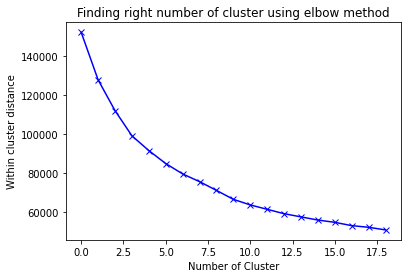

In [126]:
get_elbow_plot(DF_scaled,1,20)

**Observation:**
* Loss values reduced drastically till 8th cluster and reduced slowly after 8th cluster
* Try choosing the number of clusters to be 6 (Elbow)

## K-MEANS Clustering

In [127]:
kmeans = KMeans(6)
kmeans.fit(DF_scaled)
labels = kmeans.labels_
kmeans.cluster_centers_.shape

(6, 17)

In [128]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [DF.columns])
cluster_centers

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.356689,0.338990,0.006877,-0.107937,0.214490,-0.365694,0.973045,0.147525,0.893457,-0.455034,-0.355378,0.191894,-0.191856,-0.204307,-0.092703,0.347242,0.036154
1,-0.009490,0.373805,-0.347685,-0.225722,-0.407300,-0.081672,-0.844601,-0.362986,-0.773534,0.134166,-0.026285,-0.477429,-0.335698,-0.262158,-0.027499,-0.453032,-0.003834
2,0.500103,0.453495,1.737902,1.490405,1.371003,-0.241568,1.150323,1.791472,0.949959,-0.354999,-0.263244,2.035160,1.088637,0.929757,0.203886,0.468141,0.295444
3,1.592004,0.377934,-0.218501,-0.152537,-0.236480,1.932572,-0.457366,-0.178846,-0.420950,1.881052,1.827263,-0.263848,0.965837,0.743217,0.517512,-0.393978,-0.085354
4,1.923051,0.337717,11.212042,10.600367,7.033118,0.419625,1.046983,1.915501,0.981334,-0.258912,0.061229,5.362438,3.044064,8.098975,1.120318,1.110132,0.310863
5,-0.697932,-2.114043,-0.313295,-0.233901,-0.310972,-0.308852,-0.540974,-0.431914,-0.440515,-0.484820,-0.358621,-0.424186,-0.222063,-0.222155,-0.256698,0.267320,-0.182054


In [129]:
# Inverse transformation to understand the numbers
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [DF.columns])
cluster_centers

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,822.056418,0.957574,1017.896828,413.284866,605.027884,211.993504,0.880880,0.246467,0.719520,0.044087,0.823632,19.479610,3796.398562,1141.694359,648.165875,0.255277,11.565702
1,1544.721837,0.965822,260.370591,217.784614,42.751212,807.600900,0.151372,0.094172,0.057015,0.161992,3.069449,2.842738,3273.043962,974.223223,800.120461,0.021211,11.512187
2,2605.398031,0.984700,4716.258730,3066.203757,1650.848624,472.290953,0.952031,0.736889,0.741975,0.064105,1.452381,65.296296,8455.357143,4424.700106,1339.354119,0.290638,11.912698
3,4878.096048,0.966800,536.374299,339.257485,197.221629,5031.564411,0.306788,0.149104,0.197141,0.511562,15.718557,8.151546,8008.561387,3884.682954,2070.247117,0.038483,11.403093
4,5567.142164,0.957273,24957.905000,18186.875667,6771.029333,1858.844605,0.910556,0.773889,0.754444,0.083333,3.666667,148.000000,15570.000000,25178.882690,3475.059479,0.478409,11.933333
5,111.789174,0.376473,333.846256,204.209925,129.859489,331.193701,0.273232,0.073609,0.189366,0.038127,0.801504,4.166165,3686.491650,1090.026752,265.982462,0.231901,11.273684


In [130]:
y_kmeans = kmeans.fit_predict(DF_scaled)
y_kmeans

array([2, 1, 0, ..., 3, 2, 2], dtype=int32)

In [131]:
# concatenate the clusters labels to original dataframe
DF_cluster = pd.concat([DF, pd.DataFrame({'cluster':labels})], axis = 1)
DF_cluster.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,3
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1


# Dimensionality Reduction using TSNE and Visualize Results

In [132]:
# Performing TSNE
tsne = TSNE(n_components=TSNE_DIM, random_state=0)
tsne_data = tsne.fit_transform(DF_scaled)

In [133]:
# Create a dataframe of reduced dimensions
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))
tsne_df.head(2)

,Dim_1,Dim_2
0,25.870537,-7.521988
1,-6.084113,57.758011


In [134]:
# Concatenate cluster lables to reduced dimensions dataframe
tsne_df = pd.concat([tsne_df, pd.DataFrame({'cluster' : labels}) ], axis= 1)
tsne_df.head()

,Dim_1,Dim_2,cluster
0,25.870537,-7.521988,1
1,-6.084113,57.758011,3
2,-37.152905,2.787714,0
3,44.771980,-16.292645,1
4,21.319422,-0.488669,1


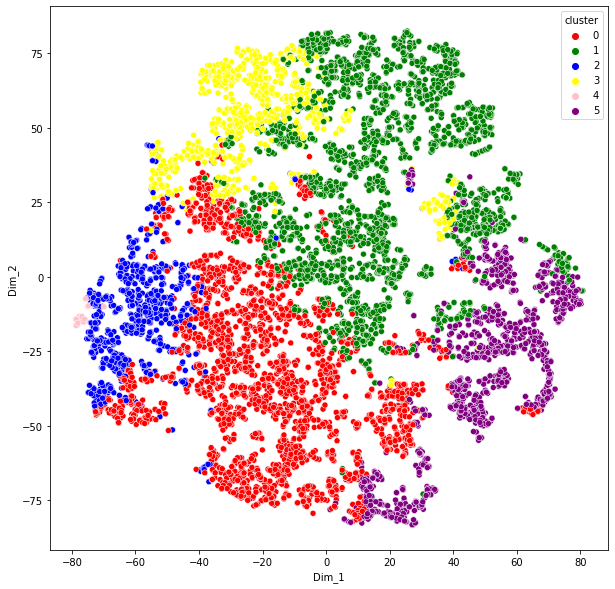

In [135]:
# Visualizing clusters
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='Dim_1', y = 'Dim_2', hue='cluster', data =tsne_df,  palette =['red','green','blue','yellow','pink','purple'])

# Dimensionality Reduction using Auto Encoders and Visualize Results

In [136]:
input = Input(shape=(17,))
x = Dense(ENCODING_DIM, activation='relu')(input)
x = Dense(units= 512, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(units= 512, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(units= 2024, activation='relu', kernel_initializer='glorot_uniform')(x)
encoded = Dense(10 , activation='relu', kernel_initializer='glorot_uniform')(x)

x = Dense(units= 2024, activation='relu', kernel_initializer='glorot_uniform')(encoded)
x = Dense(units= 512, activation='relu', kernel_initializer='glorot_uniform')(x)
decoded = Dense(17, kernel_initializer='glorot_uniform')(x)

#Encoder
encoder = Model(input, encoded)

#Autoencoder
autoencoder = Model(input, decoded)

autoencoder.compile(optimizer ='adam', loss= 'mean_squared_error')

In [137]:
autoencoder.fit(DF_scaled, DF_scaled, batch_size =128, epochs =25 , verbose =1)

Epoch 1/25
70/70 [==============================] - 1s 4ms/step - loss: 0.6064
Epoch 2/25
70/70 [==============================] - 0s 3ms/step - loss: 0.3078
Epoch 3/25
70/70 [==============================] - 0s 3ms/step - loss: 0.2375
Epoch 4/25
70/70 [==============================] - 0s 3ms/step - loss: 0.1898
Epoch 5/25
70/70 [==============================] - 0s 3ms/step - loss: 0.1555
Epoch 6/25
70/70 [==============================] - 0s 3ms/step - loss: 0.1416
Epoch 7/25
70/70 [==============================] - 0s 3ms/step - loss: 0.1220
Epoch 8/25
70/70 [==============================] - 0s 3ms/step - loss: 0.1158
Epoch 9/25
70/70 [==============================] - 0s 3ms/step - loss: 0.1074
Epoch 10/25
70/70 [==============================] - 0s 3ms/step - loss: 0.1025
Epoch 11/25
70/70 [==============================] - 0s 3ms/step - loss: 0.0942
Epoch 12/25
70/70 [==============================] - 0s 3ms/step - loss: 0.0923
Epoch 13/25
70/70 [==============================

In [138]:
pred = encoder.predict(DF_scaled)
pred.shape

(8950, 10)

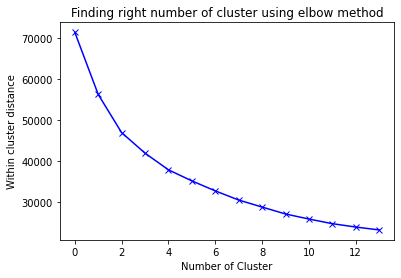

In [139]:
# finding the number of clusters required by plotting elbow plot
get_elbow_plot(pred,1,15)

In [140]:
kmeans = KMeans(4)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(DF_scaled)

In [141]:
df_cluster_dr = pd.concat([DF, pd.DataFrame({'cluster': labels})], axis=1)
df_cluster_dr.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,3
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,2
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1


In [142]:
pca = PCA(n_components=PCA_DIM)
prin_comp = pca.fit_transform(pred)
# Create a dataframe of reduced dimensions
pca_df = pd.DataFrame(data = prin_comp, columns =['PC1','PC2'])
pca_df.head()

,PC1,PC2
0,-1.107376,0.151514
1,0.949703,-1.986587
2,0.815964,1.036400
3,0.197578,0.183850
4,-0.877316,0.225250


In [143]:
# Concatenate cluster lables to reduced dimensions dataframe
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,PC1,PC2,cluster
0,-1.107376,0.151514,1
1,0.949703,-1.986587,3
2,0.815964,1.036400,2
3,0.197578,0.183850,1
4,-0.877316,0.225250,1


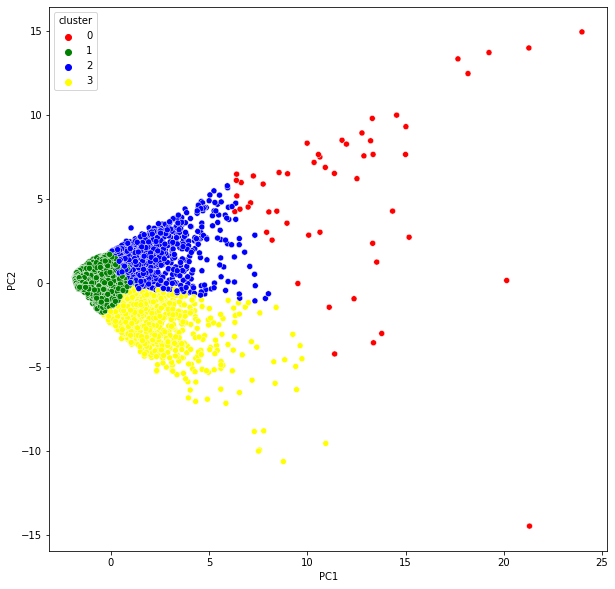

In [144]:
# Visualizing clusters
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="PC1", y="PC2", hue = "cluster", data = pca_df, palette =['red','green','blue','yellow'])
plt.show()